In [94]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord


In [9]:
# imageDirectory = '/data/mj1e16/kepler/cal/'
# medianDir = '/data/mj1e16/kepler/newDiff/'

imageDirectory = '/media/mj1e16/PP AV-TV/keplerCal/'
medianDir = '/media/mj1e16/PP AV-TV/medians/'

In [10]:
dirlist = os.listdir(imageDirectory)
dirlist = [x for x in dirlist if x[0] != '.']
imagelist = [imageDirectory+x for x in dirlist]

In [11]:
def correctExtensionOrder(imageName):
    hdu_list = fits.open(imageName)
    extensionOrder = np.zeros(len(hdu_list))
    for channel in range(1,len(hdu_list)):
        hdr = hdu_list[channel].header
        location = hdr['SKYGROUP'] # independant location
        extensionOrder[location] = channel # ordered from 0-84 channel with extension in place of name
    return extensionOrder

In [12]:
extensionOrders = []
for image in imagelist:
    extensionOrders.append(correctExtensionOrder(image))

In [21]:
def getAllccds(imagelist,pos,extensionOrders):
    names = []
    for x in range(len(imagelist)):
        extension = int(extensionOrders[x][pos])
        names.append(imagelist[x]+'[{}]'.format(extension))
    return names

In [86]:
def getIndiExt(image,imagelist,extensionOrders,imDir=imageDirectory):
    loc1 = image.find('[')
    loc2  = image.find(']')
    imagename = imDir+image[:loc1]
    pos = image[loc1+1:loc2]
    imagepos = imagelist.index(imagename)
    #extensionOrders[imagepos] = extensionOrders[imagepos].tolist()
    XO = [str(int(x)) for x in extensionOrders[imagepos]]
    indiExt = XO.index(pos)
    return indiExt

In [113]:
def findMatchesNoCondition(tab,ra,dec,max_sep = 3 * u.arcsec):
    
    df = tab.to_pandas()
    
    ra1 =[ra,ra]
    dec1 = [dec,dec]
    
    number2 = tab['OBJECT INDEX'] # difference image
    ra2 = tab['RA']
    dec2 = tab['DEC']    
    
    cat1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
    cat2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matchdf = df[df['OBJECT INDEX'].isin(objectsFound)]
    matchtab = Table.from_pandas(matchdf)
    return matchtab

In [143]:
def findDate(imageName,channel):
    hdu_list = fits.open(imageName)
    hdr = hdu_list[int(channel)].header
    date = hdr['MJDSTART'] # independant location
    return date

In [159]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [38]:
origTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [146]:
origTab

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index,diffImage,medianImage,magDiff,MAG_BEST_ORIG,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64,str32,str18,float64,float64,int64
1,4972.103,37.4395,15.7586,429.9972,24.7407,0.351,291.9081476036849,47.058497168533194,kplr2009114174833_ffi-cal.fits[58],meidian_18_58.fits,diff_imNo11_channel18_ccd58.fits,122511,diff_imNo11_channel18_ccd58.fits,meidian_18_58.fits,-4.733674110651155,15.7447,0
159,2963.834,14.20312,16.3204,618.8993,260.8472,0.059,282.2997286819453,48.51511298543987,kplr2009115131122_ffi-cal.fits[16],meidian_12_16.fits,diff_imNo49_channel12_ccd16.fits,199471,diff_imNo49_channel12_ccd16.fits,meidian_12_16.fits,-3.0588167843178122,16.2535,1
31,2797.135,14.15697,16.3832,127.6044,916.9813,0.044,286.17639521590405,44.443401074095455,kplr2009115131122_ffi-cal.fits[18],meidian_26_18.fits,diff_imNo49_channel26_ccd18.fits,26660,diff_imNo49_channel26_ccd18.fits,meidian_26_18.fits,-4.250811469125403,16.3614,2
12,2862.116,37.76081,16.3583,1039.0616,993.9548,0.413,282.51787304188844,47.587614950317615,kplr2009260000800_ffi-cal.fits[76],meidian_12_76.fits,diff_imNo14_channel12_ccd76.fits,37135,diff_imNo14_channel12_ccd76.fits,meidian_12_76.fits,-4.9381187120948,16.3467,3
68,3784.545,39.92257,16.055,341.8187,226.6804,0.071,286.16801092086166,37.67179113909842,kplr2009351005245_ffi-cal.fits[75],meidian_71_75.fits,diff_imNo28_channel71_ccd75.fits,240247,diff_imNo28_channel71_ccd75.fits,meidian_71_75.fits,-3.5398002117672567,16.0125,4
118,3451.97,23.67002,16.1548,947.2881,593.7286,0.048,284.7198297858132,41.675149597439834,kplr2010020005046_ffi-cal.fits[49],meidian_49_49.fits,diff_imNo25_channel49_ccd49.fits,125109,diff_imNo25_channel49_ccd49.fits,meidian_49_49.fits,-5.09291635990458,16.1448,5
158,3651.136,36.02952,16.0939,645.012,273.612,0.114,294.896920769719,49.00664051747236,kplr2010078174524_ffi-cal.fits[13],meidian_13_13.fits,diff_imNo31_channel13_ccd13.fits,46525,diff_imNo31_channel13_ccd13.fits,meidian_13_13.fits,-4.209689270551595,16.0712,6
42,4922.818,28.08094,15.7695,847.0221,792.5739,0.006,283.1588141524291,47.39383732680302,kplr2010078174524_ffi-cal.fits[9],meidian_9_9.fits,diff_imNo31_channel9_ccd9.fits,152817,diff_imNo31_channel9_ccd9.fits,meidian_9_9.fits,-4.343615660343915,15.7494,7
5,1774.637,20.95655,16.8772,555.793,52.6379,0.11,282.85892686984414,46.1930525322328,kplr2010140101631_ffi-cal.fits[14],meidian_10_14.fits,diff_imNo21_channel10_ccd14.fits,259586,diff_imNo21_channel10_ccd14.fits,meidian_10_14.fits,-3.1725772265789005,16.8172,8


In [39]:
origTab['OBJECT INDEX'] = range(len(origTab))

In [ ]:
getIndiExt(image,imagelist,extensionOrders)
allNames = getAllccds(imagelist,1,extensionOrders)

In [60]:
ra = origTab['RA'][0]
dec =origTab['DEC'][0]
image = origTab['IMAGE_NAME'][0]
oneimTab = ascii.read('/home/mj1e16/outTablesImproved/imagecsv/'+image+'.csv')
oneimTab['OBJECT INDEX'] = range(len(oneimTab))
testmatch = findMatchesNoCondition(image,oneimTab,ra,dec)

In [107]:
allNames

['/media/mj1e16/PP AV-TV/keplerCal/kplr2009114174833_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009114204835_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009115002613_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009115053616_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009115080620_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009115131122_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009115173611_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009116035924_ffi-cal.fits[5]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009170043915_ffi-cal.fits[33]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009231194831_ffi-cal.fits[33]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009260000800_ffi-cal.fits[33]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009292020429_ffi-cal.fits[77]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009322233047_ffi-cal.fits[77]',
 '/media/mj1e16/PP AV-TV/keplerCal/kplr2009351005245_ffi-cal.fits[77]',


In [140]:
allTabs = []
imNames = []
mag = []
#date = []
imageReDo = []
for im in range(len(origTab)):
    ra = origTab['RA'][im]
    dec =origTab['DEC'][im]
    image = origTab['IMAGE_NAME'][im]
    indiext = getIndiExt(image,imagelist,extensionOrders)
    allNames = getAllccds(imagelist,indiext,extensionOrders)
    testmatch = []
    magone = []
    imNameOne = []
    for x in range(len(allNames)):
        loc1 = allNames[x].find(imageDirectory)+len(imageDirectory)
        imNameOnly = allNames[x][loc1:]
        oneimTab = ascii.read('/home/mj1e16/outTablesImproved/imagecsv/'+imNameOnly+'.csv')
        oneimTab['OBJECT INDEX'] = range(len(oneimTab))
        if len(testmatch) == 0:
            try:
                testmatch = findMatchesNoCondition(oneimTab,ra,dec)
                if len(testmatch) != 0:
                    onemag = testmatch['MAG_BEST'][0]
                    magone.append(onemag)
                    imNameOne.append(imNameOnly)
                    #print(imNameOnly)
    #                 mag.append(testmatch['MAG_BEST'][0])
                    #imNames.append(imNameOnly)
            except:
                imageReDo.append(imNameOnly)
                print('Redo file '+imNameOnly)
        else:
            try:
                oneim = findMatchesNoCondition(oneimTab,ra,dec)

            except:
                imageReDo.append(imNameOnly)
                print('Redo file '+imNameOnly)
            if len(oneim) != 0:
                onemag = oneim['MAG_BEST'][0]
                magone.append(onemag)
                imNameOne.append(imNameOnly)
                print(imNameOnly)
                #print(testmatch['IMAGE_NAME'],oneim['IMAGE_NAME'])
                testmatch = vstack([testmatch,oneim])
                
        
                
    imNames.append(imNameOne)
    mag.append(magone)
    #allTabs.append(testmatch)
    print('index {}'.format(im),len(testmatch))

('index 0', 1)
('index 1', 1)
('index 2', 1)
kplr2010078174524_ffi-cal.fits[12]
kplr2011053174401_ffi-cal.fits[12]
kplr2012088132324_ffi-cal.fits[12]
kplr2013098115308_ffi-cal.fits[12]
('index 3', 5)
kplr2009260000800_ffi-cal.fits[15]
kplr2009292020429_ffi-cal.fits[75]
kplr2009322233047_ffi-cal.fits[75]
kplr2009351005245_ffi-cal.fits[75]
kplr2010019225502_ffi-cal.fits[71]
kplr2010020005046_ffi-cal.fits[71]
kplr2010049182302_ffi-cal.fits[71]
kplr2010078174524_ffi-cal.fits[71]
kplr2010111125026_ffi-cal.fits[11]
kplr2010140101631_ffi-cal.fits[11]
kplr2010174164113_ffi-cal.fits[11]
kplr2010203012215_ffi-cal.fits[15]
kplr2010234192745_ffi-cal.fits[15]
kplr2010265195356_ffi-cal.fits[15]
kplr2010296192119_ffi-cal.fits[75]
kplr2010326181728_ffi-cal.fits[75]
kplr2010356020128_ffi-cal.fits[75]
kplr2011024134926_ffi-cal.fits[71]
kplr2011053174401_ffi-cal.fits[71]
kplr2011116104002_ffi-cal.fits[11]
kplr2011145152723_ffi-cal.fits[11]
kplr2011177110110_ffi-cal.fits[11]
kplr2011208112727_ffi-cal.fits

In [164]:
print(origTab['RA'][30])
print(origTab['DEC'][30])

283.43281807912626
40.30387646275394


In [152]:
datesfull = []
for x in range(len(imNames)):
    #if len(imNames[x]) > 1:
    dates = []
    for y in range(len(imNames[x])):
        image = imNames[x][y]
        #print(image)
        loc1 = image.find('[')
        loc2  = image.find(']')
        imagename = imageDirectory+image[:loc1]
        #print(imagename)
        pos = image[loc1+1:loc2]
        date = findDate(imagename,pos)
        dates.append(date)
    datesfull.append(dates)

In [153]:
datesfull

[[54945.72162632],
 [54946.52913182],
 [54946.52913182],
 [55245.74556834,
  55274.71942834,
  55614.71846884,
  56014.53748484,
  56390.47480454],
 [55062.80492724,
  55090.98512704,
  55123.06602474,
  55153.95927784,
  55182.01619934,
  55215.93445914,
  55216.01483134,
  55245.74556834,
  55274.71942834,
  55307.51459974,
  55336.40771054,
  55370.67486344,
  55399.03668604,
  55430.79050564,
  55461.80869384,
  55492.78603754,
  55522.74170174,
  55552.06392474,
  55585.55556804,
  55614.71846884,
  55677.42404264,
  55706.62358874,
  55738.43871074,
  55769.45696544,
  55801.74198404,
  55832.78062804,
  55864.77969804,
  55895.73660944,
  55930.84151904,
  55958.40644554,
  55986.50257794,
  56014.53748484,
  56077.43209024,
  56105.56916384,
  56137.50692204,
  56168.81112794,
  56203.83432484,
  56236.81420744,
  56267.89370604,
  56303.65251524,
  56330.54311544,
  56357.47460744,
  56390.47480454],
 [54945.72162632,
  54945.84664962,
  54945.99778262,
  54946.21309222,
  549

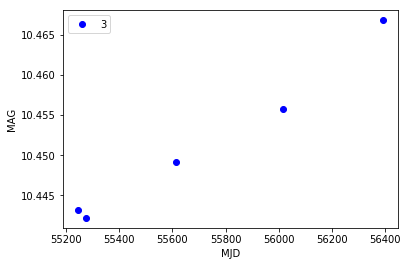

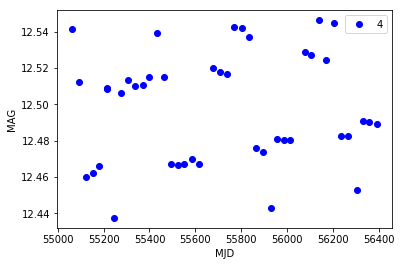

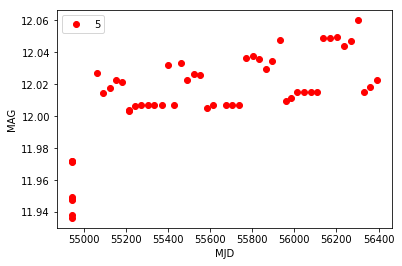

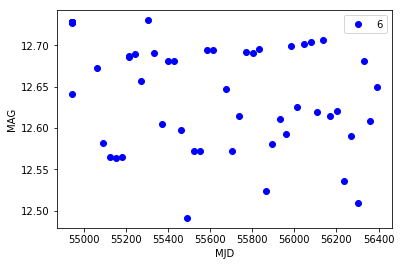

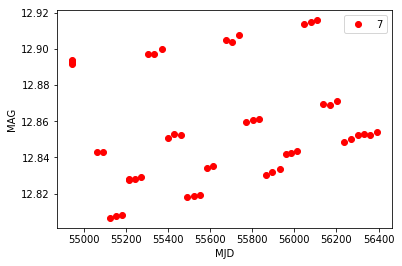

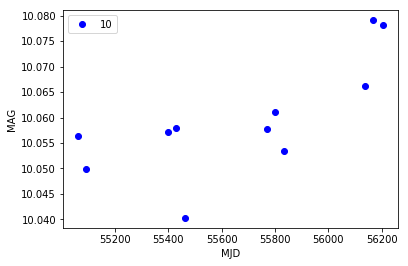

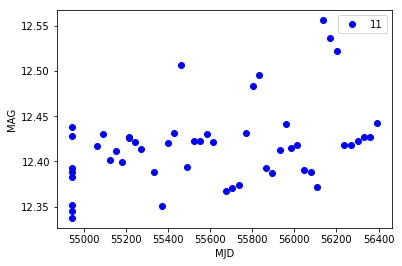

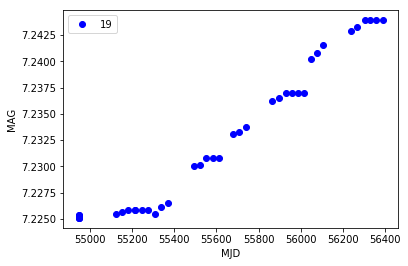

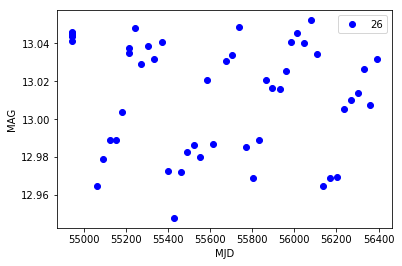

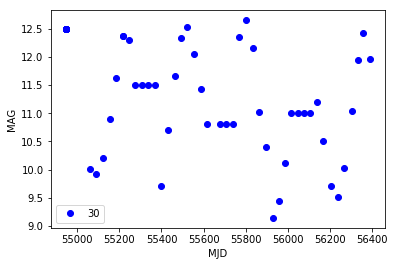

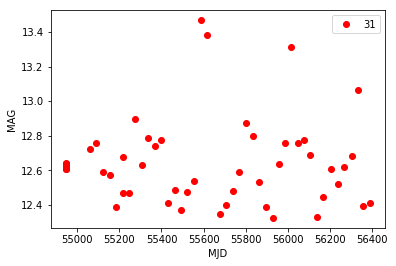

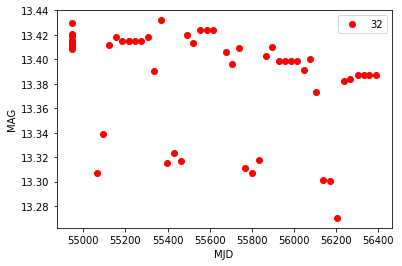

In [157]:
isThereAmatch = [5, 5, 0, 0, 0, 1, 0, 3, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 3, 4, 3, 0, 0]
for x in range(len(datesfull)):
    if len(datesfull[x]) > 1:
        if isThereAmatch[x] ==0:
            plt.plot(datesfull[x],mag[x],'bo',label=str(x))
        else:
            plt.plot(datesfull[x],mag[x],'ro',label=str(x))
        plt.ylabel('MAG')
        plt.xlabel('MJD')
        plt.legend()
        plt.show()

In [162]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType,xcoords,ycoords):
#     for tables in range(len(sexTabList)):
#         if tabType == 'dao':
#             xcoords = sexTabList[tables]['xcentroid']
#             ycoords = sexTabList[tables]['ycentroid']
#         elif tabType == 'sex':
#             xcoords = sexTabList[tables]['X_IMAGE']
#             ycoords = sexTabList[tables]['Y_IMAGE']
#         elif tabType == 'iraf':
#             xcoords = sexTabList[tables]['X_POS']
#             ycoords = sexTabList[tables]['Y_POS']        
#         else:
#             print('tab type error')
#             break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [161]:
ra = [origTab[]]
makeDS9RegFile(origTab,'/home/mj1e16/outTablesImproved/region','sex')
imagename = imageDirectory+origTab['IMAGE_NAME'][x]
subprocess.call(['ds9',imagename,'-r','/home/mj1e16/outTablesImproved/region.reg'])
#origTab['IMAGE_NAME']

TypeError: object of type 'numpy.float64' has no len()

In [147]:
for x in range(len(imNames)):
    if len(imNames[x]) > 1:
        dates = []
        for y in range(len(imNames[x])):
            image = imNames[x][y]
            #print(image)
            loc1 = image.find('[')
            loc2  = image.find(']')
            imagename = imageDirectory+image[:loc1]
            #print(imagename)
            pos = image[loc1+1:loc2]
            date = findDate(imagename,pos)
            dates.append(date)
        
        plt.plot(dates,mag[x],'o',label=str(x))
        plt.ylabel('MAG')
        plt.xlabel('MJD')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [139]:
mag

[[15.7447],
 [16.2535],
 [15.9918],
 [10.4432, 10.4422, 10.4492, 10.4557, 10.4668],
 [12.5416,
  12.512,
  12.4601,
  12.4621,
  12.4663,
  12.5091,
  12.5084,
  12.4375,
  12.5062,
  12.5132,
  12.5099,
  12.5104,
  12.5151,
  12.539,
  12.5148,
  12.4673,
  12.4665,
  12.4671,
  12.47,
  12.4669,
  12.5197,
  12.5175,
  12.5167,
  12.5425,
  12.5419,
  12.5368,
  12.4758,
  12.4738,
  12.4432,
  12.4807,
  12.4806,
  12.4802,
  12.5285,
  12.5273,
  12.5462,
  12.5245,
  12.5448,
  12.4824,
  12.4823,
  12.4526,
  12.4906,
  12.4905,
  12.4893],
 [11.9721,
  11.9715,
  11.9721,
  11.9385,
  11.9492,
  11.9364,
  11.9475,
  11.9484,
  12.0273,
  12.0142,
  12.0176,
  12.0229,
  12.0213,
  12.0035,
  12.0038,
  12.0061,
  12.0068,
  12.0068,
  12.0068,
  12.0068,
  12.032,
  12.0073,
  12.0333,
  12.0226,
  12.0267,
  12.0258,
  12.0053,
  12.0071,
  12.0071,
  12.0071,
  12.0071,
  12.0367,
  12.0375,
  12.0359,
  12.0296,
  12.0347,
  12.0477,
  12.0094,
  12.0114,
  12.0153,
  12.01

In [104]:
allTabs[0]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str30,int64
14,5036.469,65.64884,15.7447,429.82,25.2439,0.182,291.9074704436052,47.05886393568745,kplr2009114174833_ffi-cal.fits,13


In [100]:
testmatch

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str30,int64
14,5036.469,65.64884,15.7447,429.82,25.2439,0.182,291.9074704436052,47.05886393568745,kplr2009114174833_ffi-cal.fits,13


In [72]:
image = origTab['IMAGE_NAME'][0]
print(image)
loc1 = image.find('[')
loc2  = image.find(']')
print(loc1,loc2)
imagename = image[:loc1]
pos = image[loc1+1:loc2]
print(imagename,pos)

kplr2009114174833_ffi-cal.fits[58]
(30, 33)
('kplr2009114174833_ffi-cal.fits', '58')


In [65]:
subprocess.call(['ds9',imagelist[0]+'[{}]'.format(int(extensionOrders[0][1]))])

0

In [97]:
origTab

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index,diffImage,medianImage,magDiff,MAG_BEST_ORIG,OBJECT INDEX
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64,str32,str18,float64,float64,int64
1,4972.103,37.4395,15.7586,429.9972,24.7407,0.351,291.9081476036849,47.058497168533194,kplr2009114174833_ffi-cal.fits[58],meidian_18_58.fits,diff_imNo11_channel18_ccd58.fits,122511,diff_imNo11_channel18_ccd58.fits,meidian_18_58.fits,-4.733674110651155,15.7447,0
159,2963.834,14.20312,16.3204,618.8993,260.8472,0.059,282.2997286819453,48.51511298543987,kplr2009115131122_ffi-cal.fits[16],meidian_12_16.fits,diff_imNo49_channel12_ccd16.fits,199471,diff_imNo49_channel12_ccd16.fits,meidian_12_16.fits,-3.0588167843178122,16.2535,1
31,2797.135,14.15697,16.3832,127.6044,916.9813,0.044,286.17639521590405,44.443401074095455,kplr2009115131122_ffi-cal.fits[18],meidian_26_18.fits,diff_imNo49_channel26_ccd18.fits,26660,diff_imNo49_channel26_ccd18.fits,meidian_26_18.fits,-4.250811469125403,16.3614,2
12,2862.116,37.76081,16.3583,1039.0616,993.9548,0.413,282.51787304188844,47.587614950317615,kplr2009260000800_ffi-cal.fits[76],meidian_12_76.fits,diff_imNo14_channel12_ccd76.fits,37135,diff_imNo14_channel12_ccd76.fits,meidian_12_76.fits,-4.9381187120948,16.3467,3
68,3784.545,39.92257,16.055,341.8187,226.6804,0.071,286.16801092086166,37.67179113909842,kplr2009351005245_ffi-cal.fits[75],meidian_71_75.fits,diff_imNo28_channel71_ccd75.fits,240247,diff_imNo28_channel71_ccd75.fits,meidian_71_75.fits,-3.5398002117672567,16.0125,4
118,3451.97,23.67002,16.1548,947.2881,593.7286,0.048,284.7198297858132,41.675149597439834,kplr2010020005046_ffi-cal.fits[49],meidian_49_49.fits,diff_imNo25_channel49_ccd49.fits,125109,diff_imNo25_channel49_ccd49.fits,meidian_49_49.fits,-5.09291635990458,16.1448,5
158,3651.136,36.02952,16.0939,645.012,273.612,0.114,294.896920769719,49.00664051747236,kplr2010078174524_ffi-cal.fits[13],meidian_13_13.fits,diff_imNo31_channel13_ccd13.fits,46525,diff_imNo31_channel13_ccd13.fits,meidian_13_13.fits,-4.209689270551595,16.0712,6
42,4922.818,28.08094,15.7695,847.0221,792.5739,0.006,283.1588141524291,47.39383732680302,kplr2010078174524_ffi-cal.fits[9],meidian_9_9.fits,diff_imNo31_channel9_ccd9.fits,152817,diff_imNo31_channel9_ccd9.fits,meidian_9_9.fits,-4.343615660343915,15.7494,7
5,1774.637,20.95655,16.8772,555.793,52.6379,0.11,282.85892686984414,46.1930525322328,kplr2010140101631_ffi-cal.fits[14],meidian_10_14.fits,diff_imNo21_channel10_ccd14.fits,259586,diff_imNo21_channel10_ccd14.fits,meidian_10_14.fits,-3.1725772265789005,16.8172,8
